# Lets find J


**ABSTRACT** : This is a computer-vision notebook in attempt to find a pretty girl called J, who is rather miser in uploading pics in social media. It's a direct implementation of Cut-And-Paste image data-augmentation technique for a segmentation model. The number of samples for this task is very few thus the final model might actually be overfitting, but never the less its an attempt.

---

**Revsion**: 1.00

**Date**: $7^{th}$. May 2021

**Author**: Miss. J and Anshul


Let's start by mounting the google-drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the contents only-needed to be done once.

In [ ]:
%ls drive/MyDrive/lets_find_J/

detailed-test.png  final.zip  models/  unet-training-history.png


In [2]:
!unzip drive/MyDrive/lets_find_J/final.zip

Streaming output truncated to the last 5000 lines.
  inflating: final/mask/pexels-photo-110442_eXwkfpTKlm.png  
  inflating: final/mask/pexels-photo-110444_PO4KcIX55w.png  
  inflating: final/mask/pexels-photo-110817.png  
  inflating: final/mask/pexels-photo-110852.png  
  inflating: final/mask/pexels-photo-111118.png  
  inflating: final/mask/pexels-photo-111738.png  
  inflating: final/mask/pexels-photo-112128_fBW3jdq1zr.png  
  inflating: final/mask/pexels-photo-112352.png  
  inflating: final/mask/pexels-photo-112358.png  
  inflating: final/mask/pexels-photo-112361.png  
  inflating: final/mask/pexels-photo-112362.png  
  inflating: final/mask/pexels-photo-112472.png  
  inflating: final/mask/pexels-photo-113042.png  
  inflating: final/mask/pexels-photo-113694.png  
  inflating: final/mask/pexels-photo-113696.png  
  inflating: final/mask/pexels-photo-113697.png  
  inflating: final/mask/pexels-photo-113699.png  
  inflating: final/mask/pexels-photo-113709.png  
  inflating: fin

In [3]:
!pip install git+https://github.com/qubvel/segmentation_models
!pip install keras==2.3.1
!pip install tensorflow-gpu==1.15.5

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-3ayqmsyp
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-3ayqmsyp
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 4.9MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp37-none-any.whl size=33794 sha256=3af6f24ab0f5e204904da0ff9a54d4265812947f702a0ea748a9c050e909ef11
  Stored in directory: /tmp/pip-ephem-wheel-cache-7pur0_w0/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
     |████████████████████████████████| 378kB 7.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 411.0MB 39kB/s 
     |████████████████████████████████| 20.1MB 1.2MB/s 
     |████████████████████████████████| 3.8MB 45.2MB/s 
     |██████

## 1. Approach - I

Train a U-Net model with `ResNet18` backbone. I will attempt training a U-Net with not a lot of parameters to see how it performs.

In [35]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import keras
import json
from keras.preprocessing.image import ImageDataGenerator
import tqdm
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
import gc
from segmentation_models import Unet
from sklearn.model_selection import train_test_split
from keras.utils import Sequence
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import random
import cv2

# setting the constants
seed = 2021
img_size = 256
batch_size = 16
model_loc = 'drive/MyDrive/lets_find_J/models'
save_loc = 'drive/MyDrive/lets_find_J/'
model_name = 'unet_resnet18.h5'
es_patience = 3
initial_lr = 1e-4
lr_patience = 2
lr_reduction_factor = 1e-5
epochs = 10

Splitting the data to generate `train`, `validation` and `test` splits.

In [36]:
df = pd.read_csv('./final/log_meta.csv')
df['images'] = [f'{img}.png' if '.png' not in img else img for img in df['images'].values.tolist()]
df['labels'] = ['no J' if 'no_J' not in img else 'J' for img in df['images'].values.tolist()]

n_classes = len(np.unique(df['labels'].values.tolist()))

# right-now we have not created a test set but can easily do that later
df_test = df[df['group'] == 'test']
df_train = df[df['group'] == 'train']
df_train, df_val = train_test_split(df_train, test_size=0.2,
                                    stratify=df_train['labels'].values.tolist())

Defining the data generator and loading the data

In [37]:
# do not show the model the cases which are not physically possible this will help the model learn quicker
train_data_generator = ImageDataGenerator(
    rescale=1./255
)
val_data_generator = ImageDataGenerator(
    rescale=1./255
    )

train_samples = train_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = './final/img/',
    x_col = 'images',
    target_size = (img_size, img_size),
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = None,
    shuffle = False,
    validate_filenames = True,
)

train_results = train_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = './final/mask/',
    x_col = 'images',
    target_size = (img_size, img_size),
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode = None,
    shuffle = False,
    validate_filenames = True,
)

val_samples = val_data_generator.flow_from_dataframe(
    dataframe = df_val,
    directory = './final/img/',
    x_col = 'images',
    target_size = (img_size, img_size),
    batch_size = batch_size,
    color_mode = 'rgb',
    class_mode = None,
    shuffle = False,
    validate_filenames = True,
)

val_results = val_data_generator.flow_from_dataframe(
    dataframe = df_val,
    directory = './final/mask/',
    x_col = 'images',
    target_size = (img_size, img_size),
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode = None,
    shuffle = False,
    validate_filenames = True,
)


class JoinedGenerator(keras.utils.Sequence):
    def __init__(self, ip_gen, op_gen, num_classes):
        self.gen1 = ip_gen
        self.gen2 = op_gen
        self.num_classes = num_classes
        assert len(ip_gen) == len(op_gen)

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, index):
        x = self.gen1[index]
        x = x.astype(np.float32)
        y = self.gen2[index]
        y = y > 0.5
        y = y.astype(np.float32)
        if self.num_classes > 2:
          return x, tf.keras.utils.to_categorical(y, num_classes=self.num_classes)
        else:
          return x, y

    def on_epoch_end(self):
        self.gen1.on_epoch_end()
        self.gen2.on_epoch_end()
        
train_generator = JoinedGenerator(train_samples, train_results, n_classes)
val_generator = JoinedGenerator(val_samples, val_results, n_classes)

Found 6818 validated image filenames.
Found 6818 validated image filenames.
Found 1705 validated image filenames.
Found 1705 validated image filenames.


Lets now `define`, `compile` and `train` the classifier which we will be using as an encoder for the UNet model. Taking a bit of leverage and using another module built to do this.

In [38]:
model = Unet('resnet18', classes=1, activation='sigmoid',
             encoder_weights = 'imagenet', input_shape=(img_size, img_size,3))
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_37 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_37[0][0]          
____________________________________________________________________________________________

In [39]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [40]:
model.compile(Adam(lr = initial_lr), loss=bce_jaccard_loss, metrics=[iou_score, dice_coef])

Compiling the model defining callbacks for training

In [41]:
es_callback = EarlyStopping(
    monitor='val_iou_score',
    patience=es_patience,
    mode='max'
)  # only stopping if model's validation accuracy has saturated/peaked

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_iou_score',
    patience=lr_patience, verbose=1,
    factor=lr_reduction_factor
)  # reducing learning rate if validation loss doesn't deacrease

mc_callback = ModelCheckpoint(
    filepath=os.path.join(model_loc, model_name),
    monitor='val_iou_score',
    save_best_only=True,
    mode='max'
)  # saving the best model based on accuracy on validation dataset

# Defining callbacks for saving model checkpoints and early stopping
callbacks = [es_callback, mc_callback, reduce_lr_callback]

Defining the dice-coefficient and IoU 

In [42]:
train_steps = len(df_train)//batch_size
val_steps = len(df_val)//batch_size

history = model.fit(train_generator, steps_per_epoch=train_steps,
                    epochs=epochs, verbose=1, validation_data=val_generator,
                    validation_steps=val_steps, callbacks=callbacks)

Epoch 1/10
426/426 [==============================] - 110s 258ms/step - loss: 0.9175 - iou_score: 0.4570 - dice_coef: 0.6197 - val_loss: 1.0879 - val_iou_score: 0.2835 - val_dice_coef: 0.4400
Epoch 2/10
426/426 [==============================] - 106s 249ms/step - loss: 0.3837 - iou_score: 0.7408 - dice_coef: 0.8492 - val_loss: 0.3650 - val_iou_score: 0.7073 - val_dice_coef: 0.8270
Epoch 3/10
426/426 [==============================] - 106s 249ms/step - loss: 0.2223 - iou_score: 0.8543 - dice_coef: 0.9210 - val_loss: 0.3273 - val_iou_score: 0.8339 - val_dice_coef: 0.9086

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-10.
Epoch 4/10
426/426 [==============================] - 106s 249ms/step - loss: 0.1762 - iou_score: 0.8836 - dice_coef: 0.9380 - val_loss: 0.3112 - val_iou_score: 0.8344 - val_dice_coef: 0.9090
Epoch 5/10
426/426 [==============================] - 106s 249ms/step - loss: 0.1756 - iou_score: 0.8839 - dice_coef: 0.9382 - val_loss: 0.3313 - val_i

Vizualizing the training hsitory

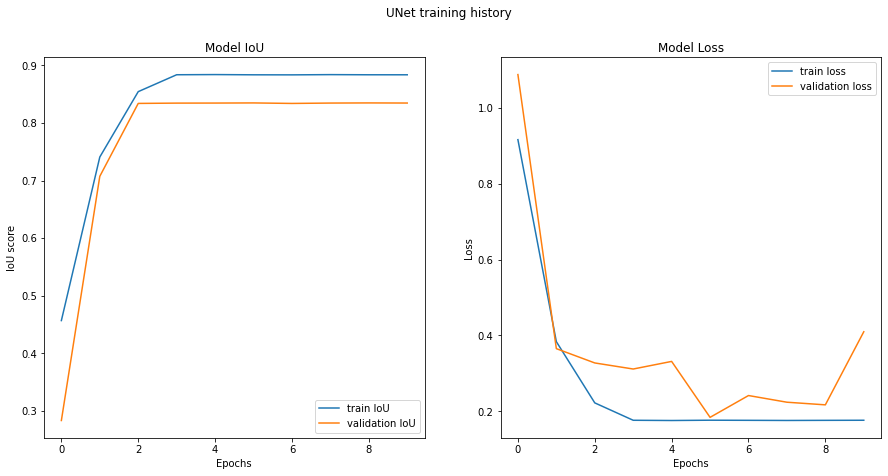

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(15, 7))
axes = fig.add_subplot(1, 2, 1)
axes.plot(history.history['iou_score'], color='C0')
axes.plot(history.history['val_iou_score'], color='C1')
axes.set(xlabel='Epochs', ylabel='IoU score', title='Model IoU')
axes.legend(['train IoU', 'validation IoU'])

axes = fig.add_subplot(1, 2, 2)
axes.plot(history.history['loss'], color='C0')
axes.plot(history.history['val_loss'], color='C1')
axes.set(xlabel='Epochs', ylabel='Loss', title='Model Loss')
axes.legend(['train loss', 'validation loss'])

plt.suptitle('UNet training history')
plt.savefig(os.path.join(save_loc, 'unet-training-history.png'))
plt.show()
plt.close()

Loading the midel

In [44]:
model.load_weights(os.path.join(model_loc, model_name))

## Testing the model,

We preserved an extremly small test set for us to make predictions on all this time, now its time to test our models performance.

In [59]:
def test_img(model, img, set_='img'):
  try:
    img_ = cv2.imread(f'./final/{set_}/{img}', cv2.COLOR_BGR2RGB)
    h,w,_ = np.shape(img_)
    img_ = cv2.resize(img_, (img_size, img_size))/255
    img_ = img_.reshape(1, img_size, img_size, 3)
    predicted_mask = (model.predict(img_)[0] > 0.5).astype(int)
    return predicted_mask*255
  except:
    return None

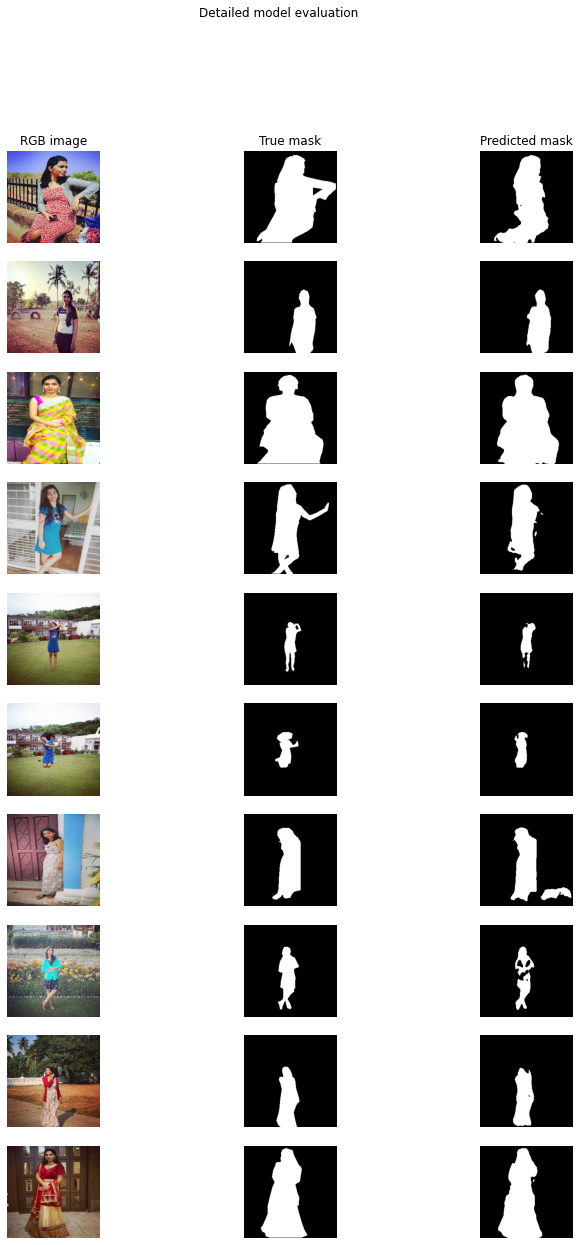

In [82]:
prediction_masks = []
for i, img in enumerate(df_test['images'].values.tolist()):
  predicted_mask = test_img(model, img)
  if predicted_mask is not None:
    prediction_masks.append(predicted_mask)

fig = plt.figure(figsize=(12, len(df_test)*2))
pred_mask = 0
for i, img in enumerate(df_test['images'].values.tolist()):
  if os.path.exists(f'./final/img/{img}'):
    plt.subplot(len(df_test), 3, 3*pred_mask+1)
    plt.imshow(np.flip(cv2.imread(f'./final/img/{img}'), axis=2))
    plt.axis('off')
    if i==0:
      plt.title('RGB image')
    
    plt.subplot(len(df_test), 3, 3*pred_mask+2)
    plt.imshow(np.repeat(cv2.imread(f'./final/mask/{img}', cv2.IMREAD_GRAYSCALE)[..., np.newaxis],
                        3, axis=2))
    plt.axis('off')
    if i==0:
      plt.title('True mask')

    plt.subplot(len(df_test), 3, 3*pred_mask+3)
    plt.imshow(np.repeat(prediction_masks[pred_mask].astype('uint8'), 3, axis=2))
    plt.axis('off')
    pred_mask += 1
    if i==0:
      plt.title('Predicted mask')

fig.suptitle('Detailed model evaluation')
plt.savefig(os.path.join(save_loc, 'detailed-test.png'))
plt.show()
plt.close()

## Testing

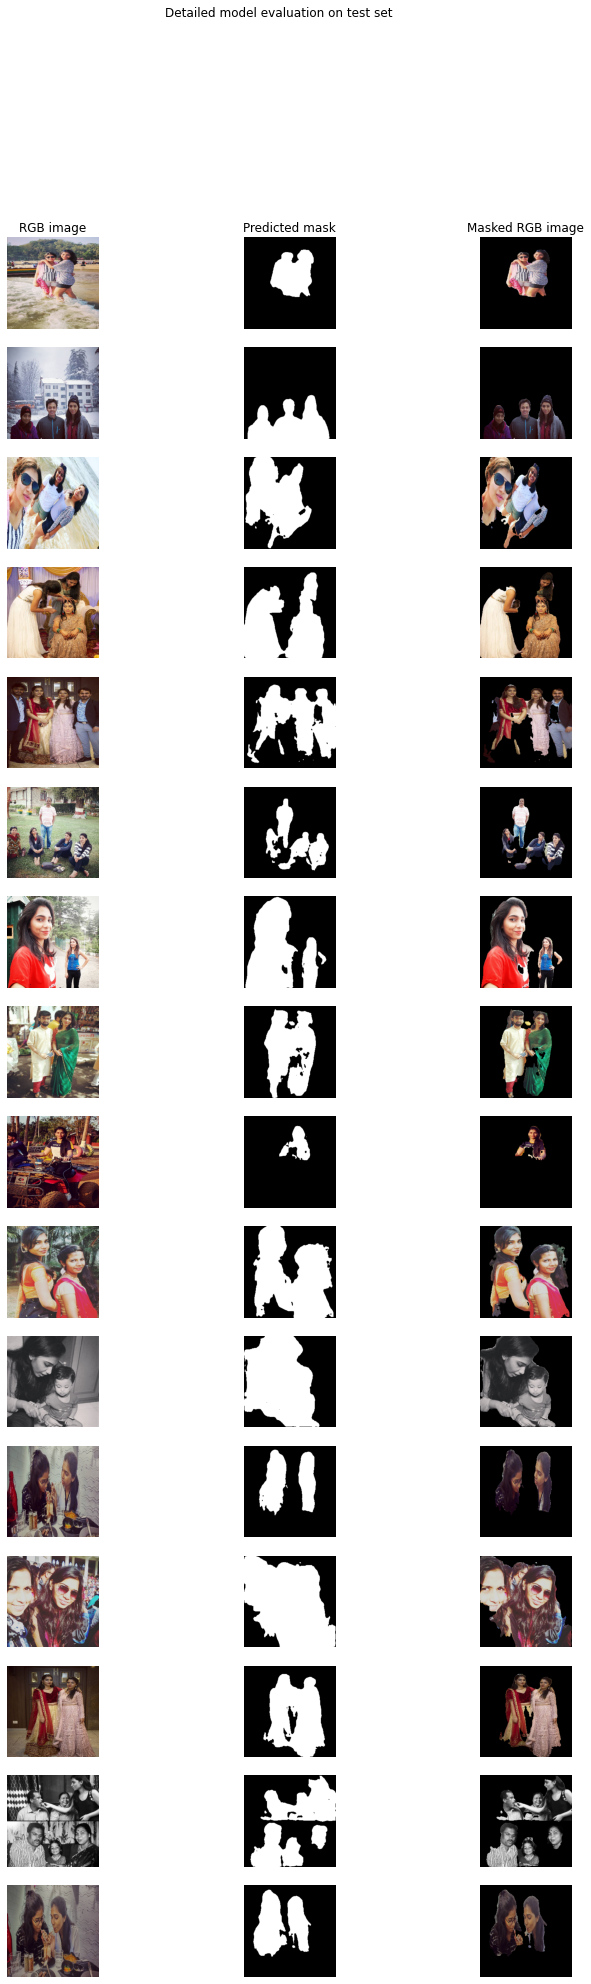

In [81]:
prediction_masks = []
for i, img in enumerate(os.listdir('./final/test')):
  predicted_mask = test_img(model, img, set_='test')
  if predicted_mask is not None:
    prediction_masks.append(predicted_mask)

fig = plt.figure(figsize=(12, len(prediction_masks)*2))
pred_mask = 0
for i, img in enumerate(os.listdir('./final/test')):
  if os.path.exists(f'./final/test/{img}'):
    plt.subplot(len(prediction_masks), 3, 3*pred_mask+1)
    img_ = cv2.imread(f'./final/test/{img}', cv2.COLOR_RGB2BGR)
    img_ = np.flip(img_, axis=2)

    plt.imshow(img_)
    plt.axis('off')
    if i==0:
      plt.title('RGB image')

    plt.subplot(len(prediction_masks), 3, 3*pred_mask+2)
    plt.imshow(np.repeat(prediction_masks[pred_mask].astype('uint8'), 3, axis=2))
    plt.axis('off')
    if i==0:
      plt.title('Predicted mask')

    plt.subplot(len(prediction_masks), 3, 3*pred_mask+3)
    # getting coordinates where the mask is not zero
    ix_, iy_, _ = np.where(prediction_masks[pred_mask] > 0)
    masked_img_ = np.zeros(np.shape(img_))
    # keeping everything zero expect where the predicted mask is non-zero
    masked_img_[ix_, iy_, :] = img_[ix_, iy_, :]
    
    plt.imshow(masked_img_.astype('uint8'))
    plt.axis('off')
    pred_mask += 1
    if i==0:
      plt.title('Masked RGB image')

fig.suptitle('Detailed model evaluation on test set')
plt.savefig(os.path.join(save_loc, 'detailed-test-for-evaluation.png'))
plt.show()
plt.close()

In [71]:
#END